In [1]:
import collections
import functools
import pickle
import PIL
from glob import glob

import numpy as np
import cv2

from skimage.morphology import skeletonize
from sklearn.preprocessing import StandardScaler

import networkx as nx

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

## Реализация построения признаков по графу

In [2]:
graph_types = {
    1: ['files/2.jpg', 'files/13.jpg', 'files/16.jpg', 'files/18.jpg'],
    2: ['files/3.jpg', 'files/25.jpg', 'files/28.jpg', 'files/29.jpg'],
    3: ['files/4.jpg', 'files/19.jpg', 'files/22.jpg', 'files/23.jpg'],
    4: ['files/5.jpg', 'files/7.jpg', 'files/9.jpg', 'files/10.jpg']
}
with open('nx_graphs.pkl', 'rb') as file:
    nx_graphs_gold = pickle.load(file)

In [3]:
def build_nx_graph_features_vector(nx_graphs):
    """
    0: Число ребер
    1: Суммарный вес ребер
    2: Число вершин
    3: Число терминальных с deg = 1
    4: Число вершин с deg = 3
    5: Число вершин с deg = 4
    6: Число вершин с deg = 5
    7: Число циклов в базисе
    8: Число петель
    
    """
    features = np.zeros(9, dtype=int)
    
    weights = nx_graphs_weights(nx_graphs)
    features[0] = weights.shape[0]
    features[1] = weights.sum()
    
    for nx_graph in nx_graphs:
        features[2] += len(nx_graph.nodes)
        degree_stat = collections.Counter(dict(nx_graph.degree(None)).values())
        features[3] += degree_stat[3] if 1 in degree_stat else 0
        features[4] += degree_stat[3] if 3 in degree_stat else 0
        features[5] += degree_stat[4] if 4 in degree_stat else 0
        features[6] += degree_stat[5] if 5 in degree_stat else 0
    features[2] -= 2 * (len(nx_graphs) - 1)
    features[3] -= 2 * (len(nx_graphs) - 1)
    
    for nx_graph in nx_graphs:
        cycles = nx.cycle_basis(nx_graph)
        features[7] += len(cycles)
        for cycle in cycles:
            if len(cycle) == 1:
                features[8] += 1
    
    return features

def determine_simple(nx_graphs, nx_graphs_gold):
    total_weights = np.array([nx_graph_weights(nx_graph).sum() for nx_graph in nx_graphs])
    target = nx_graphs[total_weights.argmax()]
    for graph_type, typical in nx_graphs_gold.items():
        if nx.is_isomorphic(typical[0], target):
            return graph_type
    return -1

def determine_hard(nx_graphs, nx_graphs_gold):
    target_features = build_nx_graph_features_vector(nx_graphs)
    
    golds = [
        (key, build_nx_graph_features_vector([gold]))
        for key, golds in nx_graphs_gold.items() for gold in golds
    ]
    golds_features = np.vstack([features for _, features in golds])
    golds_labels = np.array([key for key, _ in golds])
    
    std = StandardScaler()
    std_golds_features = std.fit_transform(golds_features)
    std_target_features = std.transform(target_features[None, :])
    
    scores = np.sqrt(((std_golds_features - std_target_features) ** 2).sum(axis=1))
    
    return golds_labels[scores.argmin()]
    
def determine_nx_graph_type(nx_graphs, nx_graphs_gold):
    total_weights = np.array([nx_graph_weights(nx_graph).sum() for nx_graph in nx_graphs])
    nx_graphs = [nx_graph for w, nx_graph in zip(total_weights, nx_graphs) if w >= 70]
    
    graph_type = determine_simple(nx_graphs, nx_graphs_gold)
    if graph_type != -1:
        return graph_type
    return determine_hard(nx_graphs, nx_graphs_gold)

## Реализации графовых обработок

In [4]:
def numpy_array_to_file(arr, filename):
    shape = np.array([len(arr.shape), *arr.shape], dtype=np.int64).tobytes()
    with open(filename, 'wb') as file:
        file.write(shape)
        file.write(arr.tobytes())

def numpy_array_from_file(filename, dtype):
    n_bytes = np.dtype(dtype).itemsize
    with open(filename, 'rb') as file:
        data = file.read()
    n_dims = np.ndarray(1, np.int64, data[:8])[0]
    shape = np.ndarray(n_dims, np.int64, data[8:8 + 8 * n_dims])
    arr = np.ndarray(shape, dtype, data[8 + 8 * n_dims:])
    return arr

def skeleton(img):
    numpy_array_to_file(img, 'temp.bin')
    !./skeleton temp.bin temp.bin
    return numpy_array_from_file('temp.bin', np.uint8)

def graphs_from_file(filename):
    graphs = []
    with open(filename, 'rb') as file:
        count_graphs = np.ndarray(1, np.int64, file.read(8))[0]
        for _ in range(count_graphs):
            count_vertexes = np.ndarray(1, np.int64, file.read(8))[0]
            vertexes = np.ndarray(count_vertexes, np.int64, file.read(8 * count_vertexes))
            count_edges = np.ndarray(1, np.int64, file.read(8))[0]
            edges = np.ndarray((count_edges, 3), np.int64, file.read(8 * 3 * count_edges))
            graphs.append((vertexes, edges))
    return graphs

def build_vertexes_with_edges(graph):
    vertexes, edges = graph
    res = {v: [] for v in vertexes}
    for first, second, length in edges:
        res[first].append((second, length))
        res[second].append((first, length))
    return res

def build_graphs(img):
    numpy_array_to_file(img, 'temp.bin')
    !./graph temp.bin temp.bin
    graphs = graphs_from_file('temp.bin')
    res = []
    for vertexes, edges in graphs:
        vertexes = sorted(vertexes)
        edges = [
            (*sorted([first, second]), length)
            for first, second, length in edges
        ]
        res.append((vertexes, edges))
    return res

def graph_delete_2_neighbors_vertexes(graph):    
    vertexes, edges = graph
    new_vertexes = []
    vertexes = build_vertexes_with_edges(graph)
    for vertex, branches in vertexes.items():
        if len(branches) != 2:
            new_vertexes.append(vertex)
        else:
            first = branches[0][0]
            second = branches[1][0]
            length = branches[0][1] + branches[1][1]
            edges.remove((*sorted([first, vertex]), branches[0][1]))
            edges.remove((*sorted([second, vertex]), branches[1][1]))
            edges.append((*sorted([first, second]), length))
            vertexes[first].remove((vertex, branches[0][1]))
            vertexes[second].remove((vertex, branches[1][1]))
            vertexes[first].append((second, length))
            vertexes[second].append((first, length))
    return new_vertexes, edges
            

def graph_pruning(graph, min_length):
    def replace(value, a, b):
        if value == a:
            return b
        else:
            return value
    
    vertexes, edges = graph
    result_edges = []
    while True:
        pair = None
        for edge in edges:
            if edge[2] < min_length:
                pair = edge[:2]
                break
        if pair is None:
            break
        big_edges = [edge for edge in edges if edge[:2] == pair and edge[2] >= min_length]
        if big_edges:
            edges = [edge for edge in edges if edge[:2] != pair or (edge[:2] == pair and edge[2] >= min_length)]
        else:
            first, second = pair
            vertexes = [v for v in vertexes if v != second]
            edges = [
                (*sorted([replace(edge[0], second, first), replace(edge[1], second, first)]), edge[2])
                for edge in edges if edge[:2] != pair
            ]
        vertexes, edges = graph_delete_2_neighbors_vertexes((vertexes, edges))
    
    return vertexes, edges

def nx_graphs_weights(nx_graphs):
    return np.hstack([nx_graph_weights(nx_graph) for nx_graph in nx_graphs])

def nx_graph_weights(nx_graph):
    return np.array([w['weight'] for _, _, w in nx_graph.edges.data()])

def graph_convert_to_nx(graph):
    vertexes, edges = graph
    nx_graph = nx.Graph()
    nx_graph.add_nodes_from(vertexes)
    nx_graph.add_weighted_edges_from(edges)
    return nx_graph

def get_nx_graph(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    img_color = cv2.imread(filename, cv2.IMREAD_COLOR)
    hsv = bgr_to_hsv(img_color)
    bright = hsv[2].mean()
    if bright < 60:
        c = 25
        is_inter = True
    else:
        c = 36
        is_inter = False
    green = find_light_green(img_color, is_inter=is_inter)
    green_contours = leave_only_area_threshold_contours(200)(find_contours(green)[0])
    circles = get_all_black_circles(img_color, c=c, close_to=green_contours)
    for circle in circles:
        center, radius = circle
        cv2.circle(green, center, 30, (255, 255, 255), cv2.FILLED)
    green = opening(3)(green)
    green = closing(25)(green)
    skel = skeletonize(green)
    skel = np.array(skel, dtype=np.uint8)
    skel[skel != 0] = 255
    graphs = build_graphs(skel)
    pruned = [graph_pruning(graph, 40) for graph in graphs]
    return [graph_convert_to_nx(p) for p in pruned]

## Реализации преобразований изображения

In [5]:
def rescale(img, new_shape):
    if not isinstance(new_shape, tuple):
        width = round(img.shape[1] * new_shape)
        height = round(img.shape[0] * new_shape)
        new_shape = (width, height)
    return cv2.resize(img, new_shape, interpolation=cv2.INTER_CUBIC)

In [6]:
def change_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def bgr_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def bgr_to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

In [7]:
def show(img, show_=True):
    max_edge = 8.0
    alpha = max_edge / max(img.shape[0], img.shape[1])
    size = (alpha * img.shape[1], alpha * img.shape[0])
    plt.figure(figsize=size)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(change_rgb(img))
    plt.axis('off')
    if show_:
        plt.show()

In [8]:
def opening(n):
    kernel = np.ones((n, n), dtype=np.uint8)
    
    def wrapper(img):
        return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    
    return wrapper

def closing(n):
    kernel = np.ones((n, n), dtype=np.uint8)
    
    def wrapper(img):
        return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    
    return wrapper

def dilate(n):
    kernel = np.ones((n, n), dtype=np.uint8)
    
    def wrapper(img):
        return cv2.dilate(img, kernel, iterations=1)
    
    return wrapper

def erode(n):
    kernel = np.ones((n, n), dtype=np.uint8)
    
    def wrapper(img):
        return cv2.erode(img, kernel, iterations=1)
    
    return wrapper

In [9]:
def bitwise_or(imgs):
    res = imgs[0]
    for img in imgs[1:]:
        res = cv2.bitwise_or(res, img)
    return res

def bitwise_and(imgs):
    res = imgs[0]
    for img in imgs[1:]:
        res = cv2.bitwise_and(res, img)
    return res

def get_masked_image(img, contours, do_dilate=None):
    mask = np.zeros(img.shape, dtype=np.uint8)
    mask = cv2.drawContours(mask, contours, -1, color=(255, 255, 255), thickness=cv2.FILLED)
    if do_dilate is not None:
        mask = dilate(do_dilate)(mask)
    return cv2.bitwise_and(img, mask)

def leave_only_area_threshold_contours(threshold, inv=False):
    def wrapper(contours):
        if not inv:
            return list(filter(lambda x: cv2.contourArea(x) >= threshold, contours))
        else:
            return list(filter(lambda x: cv2.contourArea(x) < threshold, contours))
    return wrapper

def threshold(low, high, is_invert=False):
    mode = cv2.THRESH_BINARY_INV if is_invert else cv2.THRESH_BINARY
    
    def wrapper(img):
        _, img_thr = cv2.threshold(img, low, high, mode)
        return img_thr
    
    return wrapper

def kirshe_operator(img):
    def rotate(arr):
        n = arr.shape[0]
        res = np.array(arr)
        res[0, :n - 1] = arr[0, 1:n]
        res[1:n, 0] = arr[:n - 1, 0]
        res[n - 1, 1:n] = arr[n - 1, :n - 1]
        res[:n - 1, n - 1] = arr[1:n, n - 1]
        return res
    
    kernel = np.array([
        [-3, -3, 5],
        [-3, 0, 5],
        [-3, -3, 5]
    ])
    kernels = []
    for _ in range(8):
        kernels.append(kernel)
        kernel = rotate(kernel)
    
    imgs = [np.abs(cv2.filter2D(img, -1, kernel)) for kernel in kernels] 
    return functools.reduce(np.maximum, imgs, np.zeros(img.shape, dtype=np.uint8))

## Алгоритмы поиска и обработки контуров

In [10]:
def get_areas(contours):
    return np.array(list(map(cv2.contourArea, contours)))

def find_black(img, contours=None, c=18):
    hsv = bgr_to_hsv(img)
    sm = ((0, 0, 0), (255, 255, c))
    # sm = ((0, 48, 0), (255, 191, 32))
    mask = cv2.inRange(hsv, *sm)
    if contours is not None:
        mask = mask_all_contours(mask, contours, 0)
    return mask

def find_light_green(img, contours=None, is_inter=False):
    hsv = bgr_to_hsv(img)
    masks = []
    masks.append(cv2.inRange(hsv, (77, 27, 120), (255, 255, 255)))
    if is_inter:
        masks.append(cv2.inRange(hsv, (41, 20, 20), (70, 255, 255)))
        masks.append(cv2.inRange(hsv, (27, 23, 21), (63, 134, 153)))
    else:
        masks.append(cv2.inRange(hsv, (81, 30, 108), (100, 114, 253)))
        masks.append(cv2.inRange(hsv, (54, 23, 110), (110, 110, 255)))
        masks.append(cv2.inRange(hsv, (45, 45, 27), (93, 115, 233)))
    mask = bitwise_or(masks)
    if contours is not None:
        mask = mask_all_contours(mask, contours, 0)
    return mask

def find_contours(img):
    contours, hierarchy = cv2.findContours(img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    return contours, hierarchy

def get_circles(contours):
    return [cv2.minEnclosingCircle(contour) for contour in contours]

def get_all_black_circles(colored_image, c=33, close_to=None):
    colored_image = rescale(rescale(colored_image, 0.75), 1 / 0.75)
    mask = opening(3)(find_black(colored_image, c=c))
    if close_to is not None:
        contours, _ = find_contours(mask)
        res = []
        for contour in contours:
            if minDistanceToContours(contour, close_to) <= 10:
                res.append(contour)
        mask = get_masked_image(mask, res, 3)
    mask = dilate(17)(mask)
    contours, _ = find_contours(mask)
    circles = get_circles(contours)
    res = []
    for circle in circles:
        center, radius = circle
        center = (round(center[0]), round(center[1]))
        radius = round(radius)
        res.append((center, radius))
    return res

def minDistance(X, Y):
    X = X[:, 0, :]
    Y = Y[:, 0, :]
    answer = np.linalg.norm(X, axis=-1)[:, None] ** 2 + \
        np.linalg.norm(Y, axis=-1)[None, :] ** 2 - (2.0 * X) @ Y.T
    answer[answer < 0] = 0
    return np.sqrt(answer).min()

def minDistanceToContours(contour, contours):
    return min(*[minDistance(contour, cont) for cont in contours])

## Пример всего пути обработки изображения

files/2.jpg


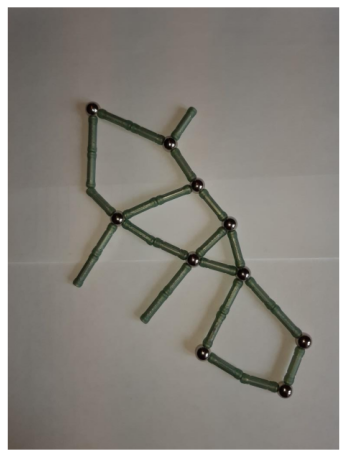

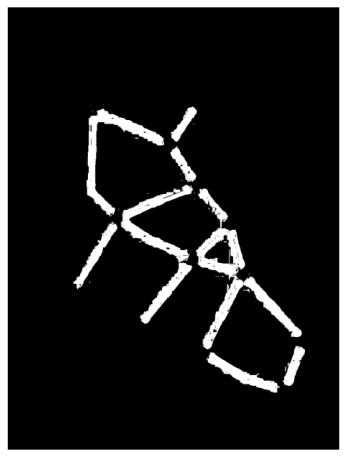

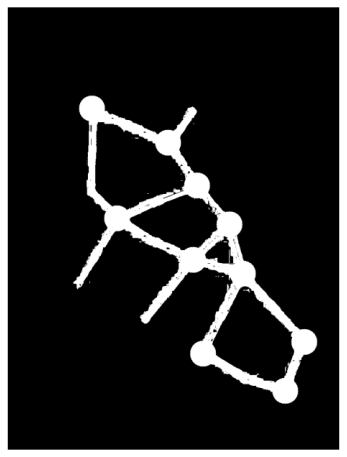

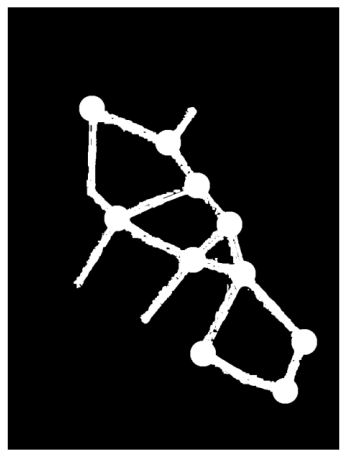

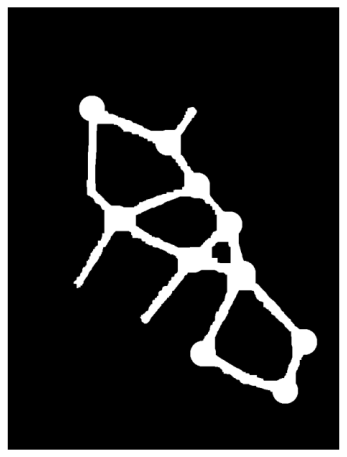

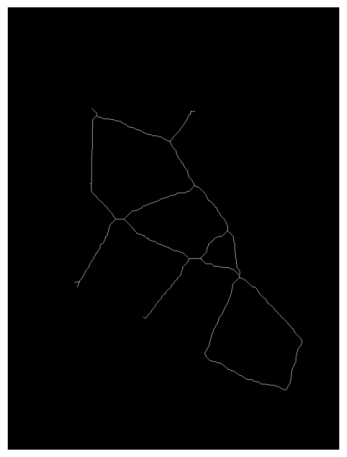

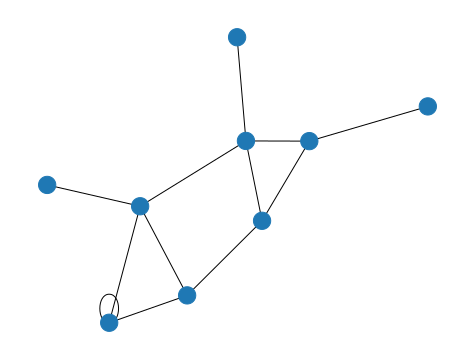

In [11]:
filename = 'files/2.jpg'
print(filename)
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
img_color = cv2.imread(filename, cv2.IMREAD_COLOR)
show(img_color)
hsv = bgr_to_hsv(img_color)
bright = hsv[2].mean()
if bright < 60:
    c = 25
    is_inter = True
else:
    c = 36
    is_inter = False
green = find_light_green(img_color, is_inter=is_inter)
show(green)
green_contours = leave_only_area_threshold_contours(200)(find_contours(green)[0])
circles = get_all_black_circles(img_color, c=c, close_to=green_contours)
for circle in circles:
    center, radius = circle
    cv2.circle(green, center, 30, (255, 255, 255), cv2.FILLED)
show(green)
green = opening(3)(green)
show(green)
green = closing(25)(green)
show(green)
skel = skeletonize(green)
skel = np.array(skel, dtype=np.uint8)
skel[skel != 0] = 255
show(skel)
graphs = build_graphs(skel)
pruned = [graph_pruning(graph, 30) for graph in graphs]
nx_graphs = [graph_convert_to_nx(p) for p in pruned]
for nx_graph in nx_graphs:
    pos = nx.spring_layout(nx_graph, seed=2760) 
    nx.draw(nx_graph, pos)
    plt.show()

In [12]:
determine_nx_graph_type(nx_graphs, nx_graphs_gold)

1

In [13]:
nx_graph_1 = get_nx_graph('files/9.jpg')
nx_graph_2 = get_nx_graph('files/10.jpg')
nx.is_isomorphic(nx_graph_1[0], nx_graph_2[0])

False

## Достаем признаки из графа

In [14]:
nx_graphs = get_nx_graph('files/16.jpg')

for nx_graph in nx_graphs:
    degree_stat = sorted(collections.Counter(dict(nx_graph.degree(None)).values()).items())
    print(degree_stat)

[(1, 3), (3, 3), (4, 3)]


In [15]:
for nx_graph in nx_graphs:
    print(nx.cycle_basis(nx_graph))

[[491055, 654906, 332482], [239103, 367123, 491055, 332482], [239103, 327054, 367123], [327054]]


In [16]:
test_indices = np.random.choice(4, 4)
temp_gold = {
    key: [val for jdx, val in enumerate(vals) if test_indices[idx] != jdx][:1]
    for idx, (key, vals) in enumerate(nx_graphs_gold.items())
}

test = [vals[test_indices[idx]] for idx, (key, vals) in enumerate(nx_graphs_gold.items())]
print(test_indices)

[3 1 3 3]


In [17]:
for t in test:
    target = [t]
    print(determine_nx_graph_type(target, nx_graphs_gold), determine_hard(target, temp_gold))

1 1
2 2
3 3
4 4


## Картинки типов графов

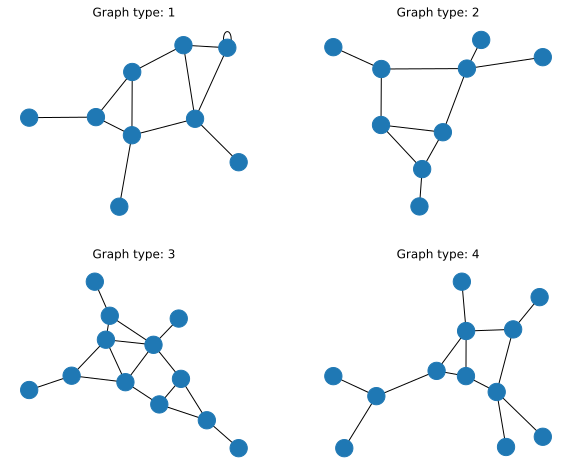

In [18]:
data = [(1, 'files/2.jpg', 220), (2, 'files/3.jpg', 220), (3, 'files/4.jpg', 230), (4, 'files/5.jpg', 230)]
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, (graph_type, name, ranom_state) in zip(axes.ravel(), data):
    nx_graph = get_nx_graph(name)[0]
    pos = nx.spring_layout(nx_graph, seed=ranom_state) 
    nx.draw(nx_graph, pos, ax=ax)
    ax.title.set_text('Graph type: {}'.format(graph_type))

fig.savefig('data/graph_types.svg', bbox_inches='tight')
plt.show()

## Попытки объединить вершины, находящиеся внутри одной окружности

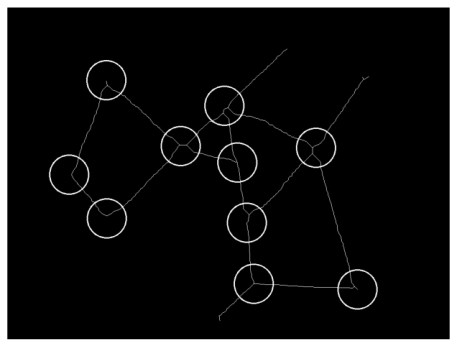

In [24]:
temp = skel.copy()
for circle in circles:
    center, radius = circle
    cv2.circle(skel, center, 45, (255, 0, 0), 2)
show(skel)

## Определение сложности картинки по уровню яркости

In [25]:
hsv = bgr_to_hsv(cv2.imread('files/2.jpg', cv2.IMREAD_COLOR))
hsv[2].mean()

50.08940972222222

In [26]:
hsv = bgr_to_hsv(cv2.imread('files/10.jpg', cv2.IMREAD_COLOR))
hsv[2].mean()

71.18012152777777

## Применение бинаризации ко всем 16 изображениям

files/13.jpg
Inter


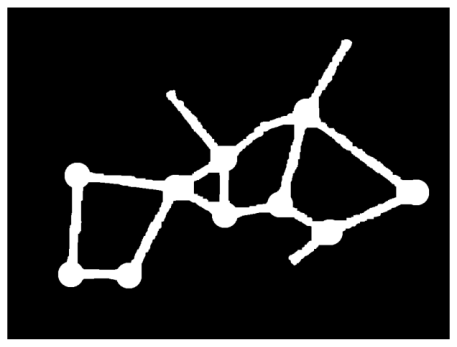

files/5.jpg
Inter


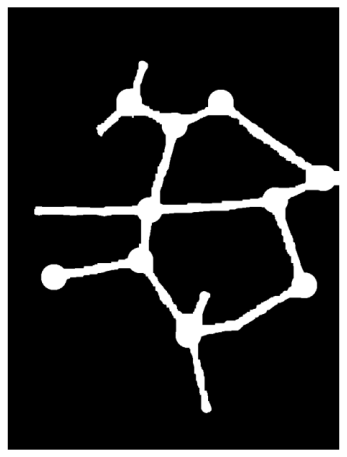

files/25.jpg
Inter


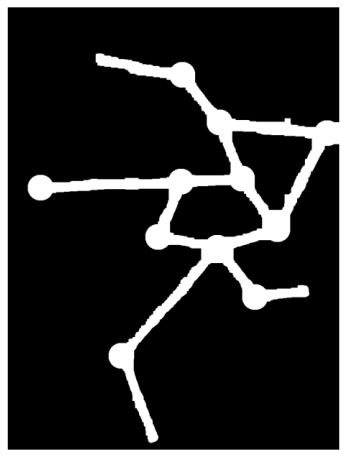

files/28.jpg
Expert


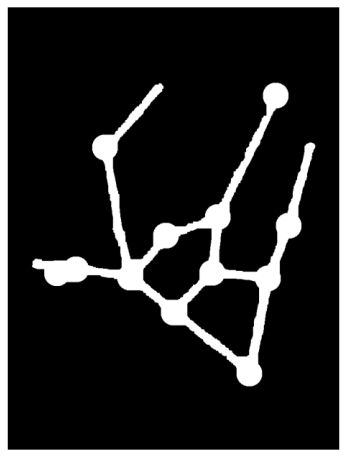

files/16.jpg
Expert


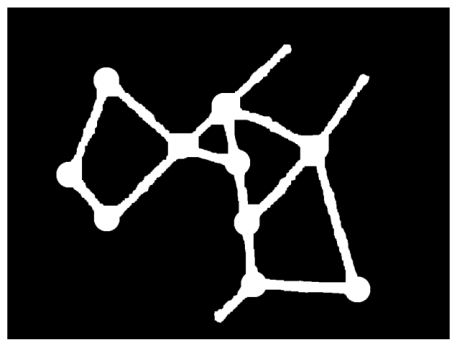

files/10.jpg
Expert


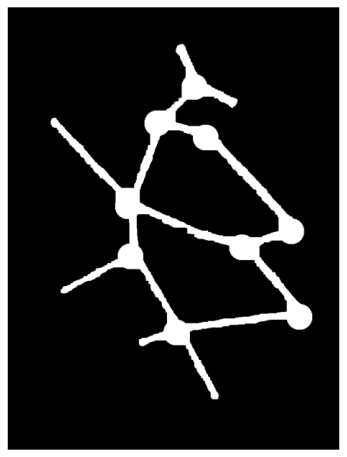

files/23.jpg
Expert


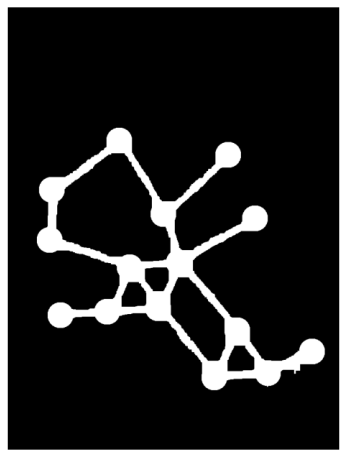

files/9.jpg
Expert


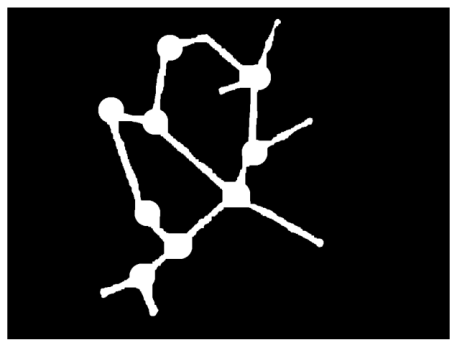

files/29.jpg
Expert


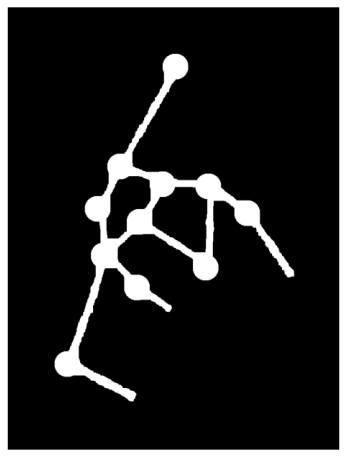

files/2.jpg
Inter


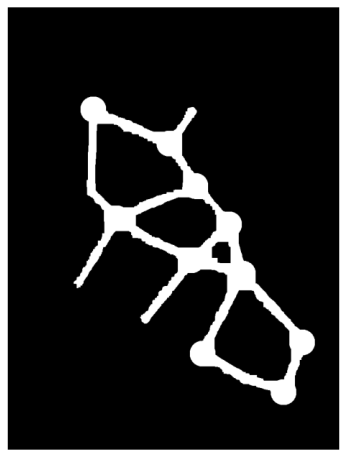

files/22.jpg
Expert


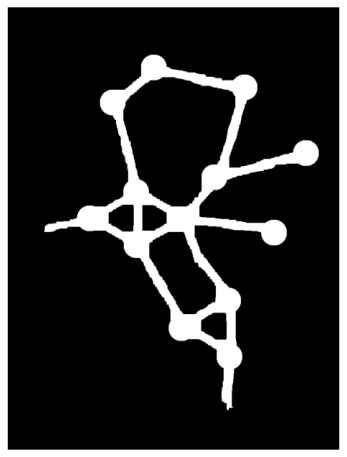

files/3.jpg
Inter


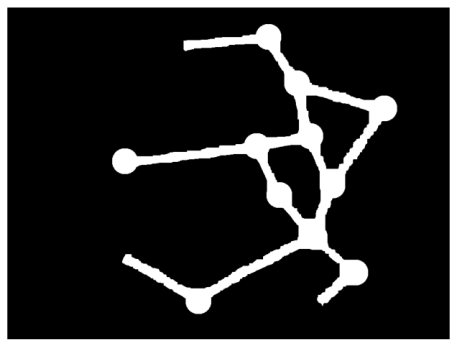

files/4.jpg
Inter


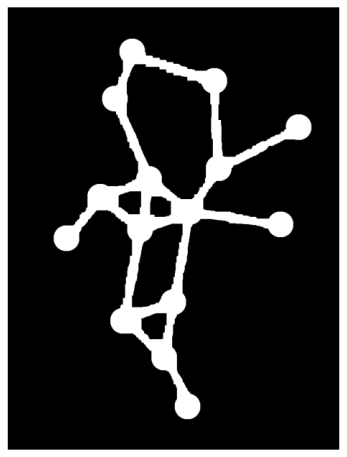

files/19.jpg
Inter


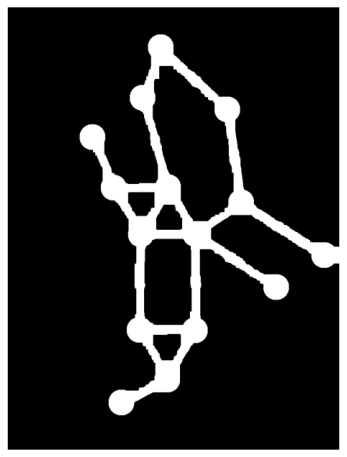

files/7.jpg
Inter


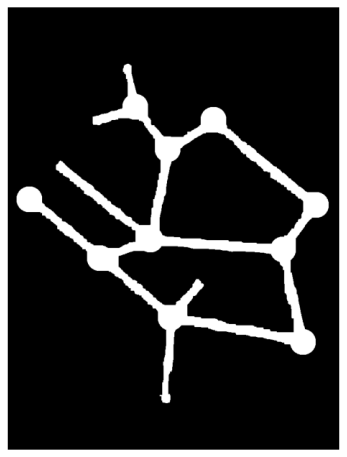

files/18.jpg
Expert


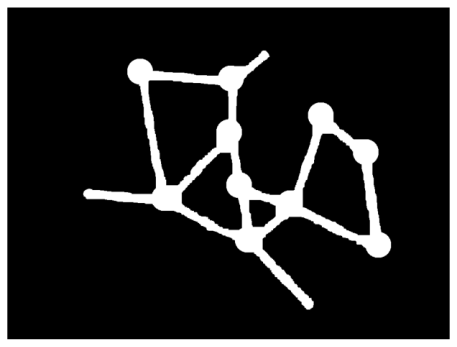

In [81]:
for filename in glob('files/*.jpg'):
    print(filename)
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    img_color = cv2.imread(filename, cv2.IMREAD_COLOR)
    hsv = bgr_to_hsv(img_color)
    bright = hsv[2].mean()
    if bright < 60:
        print('Inter')
        c = 16
        is_inter = True
    else:
        print('Expert')
        c = 35
        is_inter = False
    green = find_light_green(img_color, is_inter=is_inter)
    green_contours = leave_only_area_threshold_contours(200)(find_contours(green)[0])
    circles = get_all_black_circles(img_color, c=c, close_to=green_contours)
    for circle in circles:
        center, radius = circle
        cv2.circle(green, center, 30, (255, 255, 255), cv2.FILLED)
    green = opening(3)(green)
    green = closing(25)(green)
    contours, _ = find_contours(green)
    areas = get_areas(contours)
    graph = contours[areas.argmax()]
    green = get_masked_image(green, [graph])
    show(green)

## Intermediate

In [21]:
filename = 'files/3.jpg'
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
img_color = cv2.imread(filename, cv2.IMREAD_COLOR)

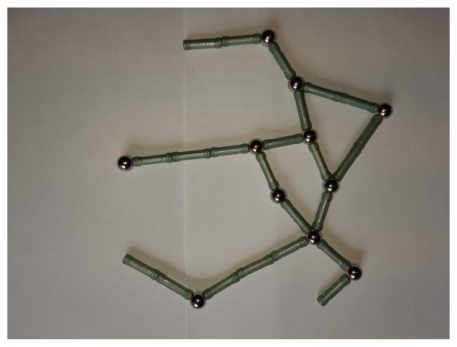

In [22]:
show(img_color)

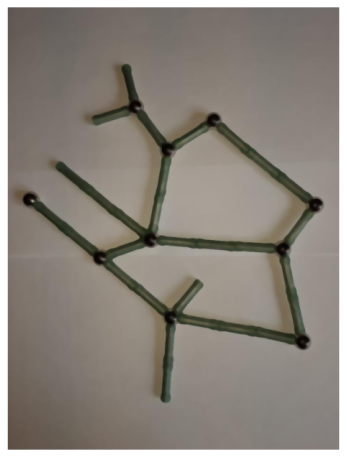

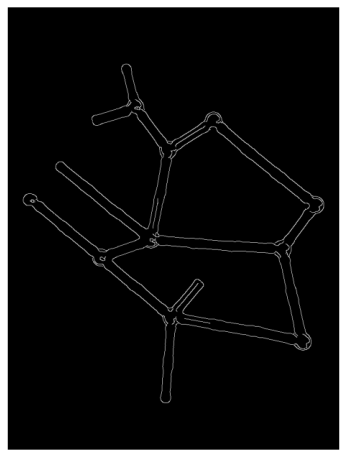

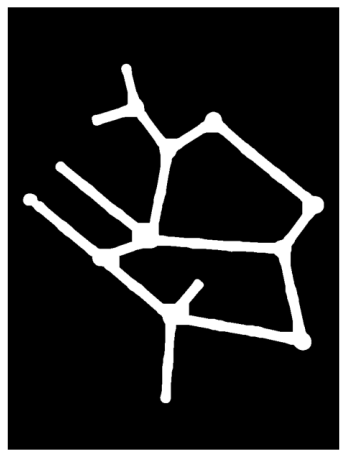

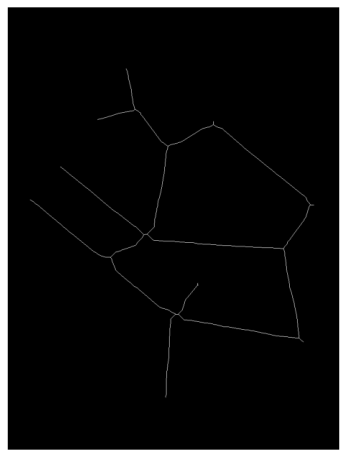

In [45]:
blured = cv2.medianBlur(img_color, 9)
show(blured)
edges = cv2.Canny(blured, 100, 200)
show(edges)
simple_bin = closing(27)(edges)
show(simple_bin)
skel = skeletonize(simple_bin)
skel = np.array(skel, dtype=np.uint8)
skel[skel != 0] = 255
show(skel)

In [46]:
circles = get_all_black_circles(img_color, c=25)
circles = list(filter(lambda x: x[1] > 7, circles))
circles

[((683, 774), 26),
 ((375, 718), 27),
 ((211, 580), 28),
 ((634, 558), 27),
 ((328, 537), 27),
 ((713, 457), 27),
 ((51, 445), 26),
 ((367, 328), 27),
 ((474, 261), 28),
 ((286, 202), 54)]

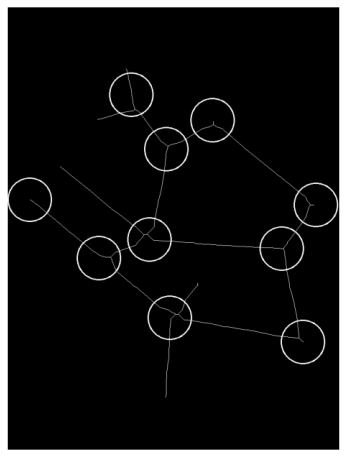

In [47]:
temp = skel.copy()
for circle in circles:
    center, radius = circle
    cv2.circle(temp, center, 50, (255, 0, 0), 2)
show(temp)

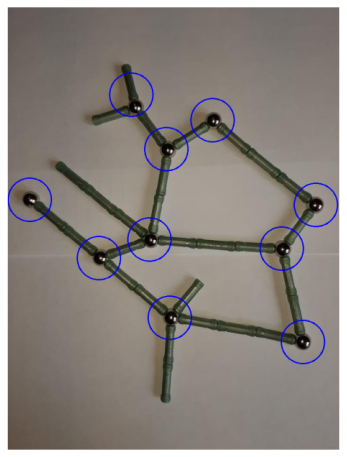

In [48]:
temp = img_color.copy()
for circle in circles:
    center, radius = circle
    cv2.circle(temp, center, 50, (255, 0, 0), 2)
show(temp)

## Построения картинок для отчета

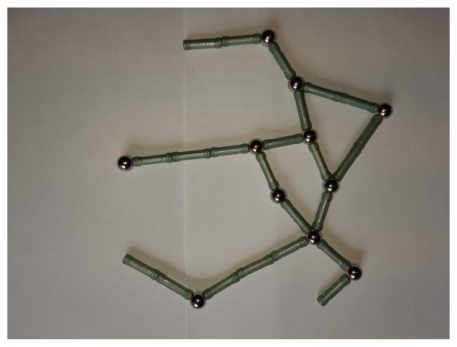

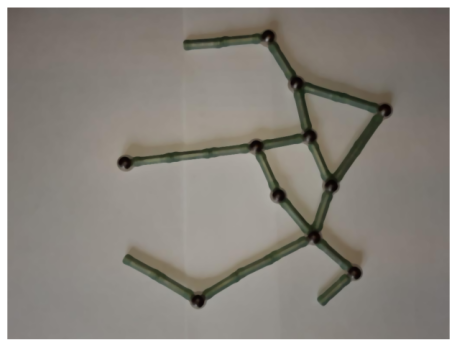

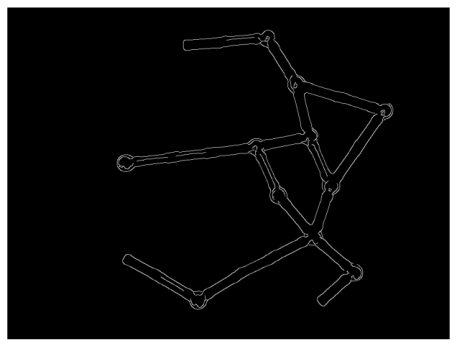

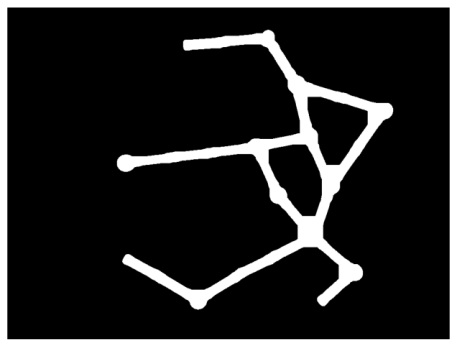

In [14]:
filename = 'files/3.jpg'

img_color = cv2.imread(filename, cv2.IMREAD_COLOR)
show(img_color, show_=False)
plt.savefig('data/median_blur_start.svg')
plt.show()

blured = cv2.medianBlur(img_color, 9)
show(blured, show_=False)
plt.savefig('data/median_blur.svg')
plt.show()

edges = cv2.Canny(blured, 100, 200)
show(edges, show_=False)
plt.savefig('data/edges.svg', bbox_inches='tight')
plt.show()

simple_bin = closing(31)(edges)
show(simple_bin, show_=False)
plt.savefig('data/inter_bin.svg', bbox_inches='tight')
plt.show()

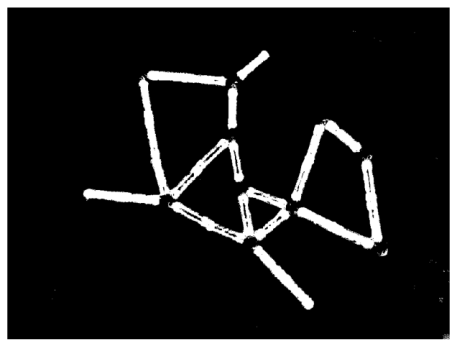

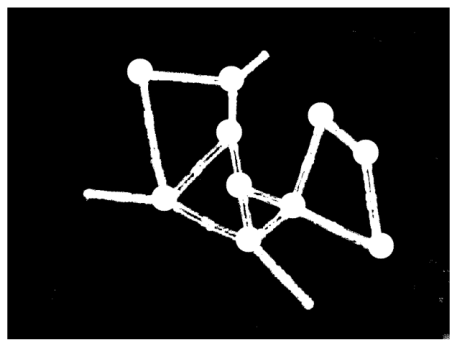

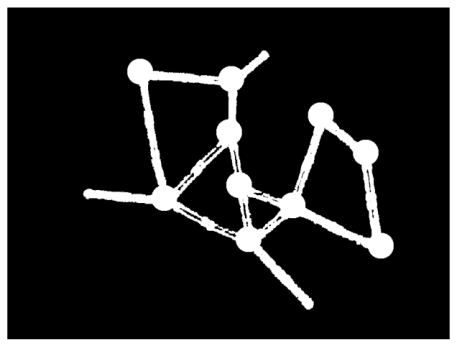

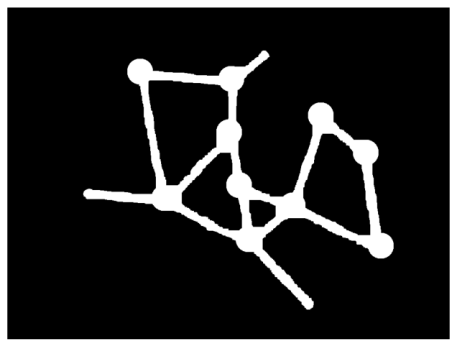

In [22]:
filename = 'files/18.jpg'

img_color = cv2.imread(filename, cv2.IMREAD_COLOR)

c = 36
is_inter = False
green = find_light_green(img_color, is_inter=is_inter)

show(green, show_=False)
plt.savefig('data/expert_green.svg', bbox_inches='tight')
plt.show()

green_contours = leave_only_area_threshold_contours(200)(find_contours(green)[0])
circles = get_all_black_circles(img_color, c=c, close_to=green_contours)

for circle in circles:
    center, radius = circle
    cv2.circle(green, center, 30, (255, 255, 255), cv2.FILLED)

show(green, show_=False)
plt.savefig('data/expert_with_circles.svg', bbox_inches='tight')
plt.show()
    
green = opening(3)(green)

show(green, show_=False)
plt.savefig('data/expert_del_noise.svg', bbox_inches='tight')
plt.show()

binary_image = closing(25)(green)

show(binary_image, show_=False)
plt.savefig('data/expert_bin.svg', bbox_inches='tight')
plt.show()

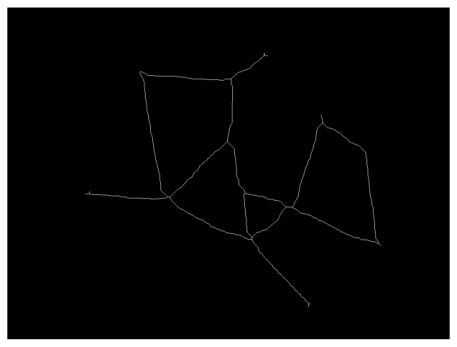

In [23]:
skel = skeletonize(binary_image)
skel = np.array(skel, dtype=np.uint8)
skel[skel != 0] = 255

show(skel, show_=False)
plt.savefig('data/skeleton.svg', bbox_inches='tight')
plt.show()

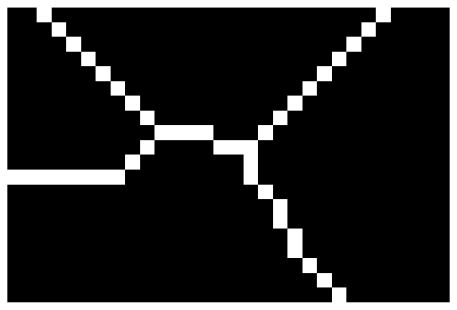

In [68]:
crop = skel[430:450,360:390]

show(crop, show_=False)
plt.savefig('data/crop_1.svg', bbox_inches='tight')
plt.show()

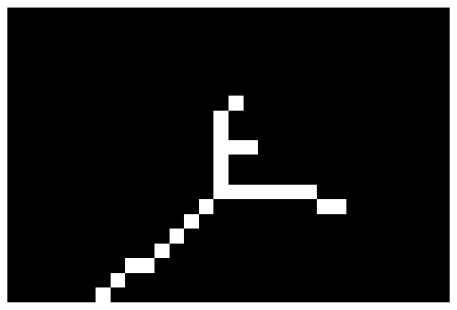

In [67]:
crop = skel[100:120, 580:610]

show(crop, show_=False)
plt.savefig('data/crop_2.svg', bbox_inches='tight')
plt.show()